# Задание 2.2: Exploitation (Оптимизация)

In [1]:
from IPython.display import Image, Math
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Dict, List, Tuple, Any, Union
from scipy import stats
import random

# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Для логгирования
import logging
logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

In [2]:
def log_uplifts(
    constraints: Dict[str, float],
    maximized_column: str,
    optimal_statistics: Dict[str, float],
) -> None:
    """
    Функция для логирования значений метрик и их аплифтов (улучшений).

    :param constraints: Словарь ограничений для метрик.
    :param maximized_column: Название столбца, который подлежит максимизации.
    :param optimal_statistics: Словарь с оптимальными статистическими данными.
    """
    # Логируем значение метрики, которую мы максимизируем
    logger.info(f"Metric: {maximized_column}", extra={"value": optimal_statistics.get(maximized_column)})

    # Проходим по всем метрикам и их ограничениям
    for metric, constraint in constraints.items():
        optimal_value = optimal_statistics.get(metric)
        if optimal_value is None:
            raise ValueError(f"`{metric}` has not been counted")
        # Логируем информацию по каждой метрике, включая аплифты
        log_dict = {
            "constraint value": round(constraint, 3),
            "optimal value": round(optimal_value, 3),
            "uplift (abs)": round(optimal_value - constraint, 3),
            "uplift (pct)": round(optimal_value * 100 / constraint - 100, 3),
        }
        logger.info(f"Metric: {metric}")
        for key, value in log_dict.items():
            logger.info(f"{key}= {value}")


def apply_constraints(
    df: pd.DataFrame,
    constraints: Dict[str, float],
) -> pd.DataFrame:
    """
    Фильтруем датасет по заданным ограничениям.

    :param df: DataFrame с данными для фильтрации.
    :param constraints: Словарь ограничений для каждой метрики.
    :return: Отфильтрованный DataFrame.
    """
    # Применяем ограничения к датафрейму, фильтруя строки
    for metric, constraint in constraints.items():
        df = df[df[metric] >= constraint]
    return df


def calculate_cum_lambda_metrics(
    df: pd.DataFrame,
    agg_columns: List[str],
    maximized_column: str,
) -> pd.DataFrame:
    """
    Считаем агрегированные значения метрик для каждой комбинации лямбда-значений.

    :param df: DataFrame с данными.
    :param agg_columns: Список столбцов для агрегации.
    :param maximized_column: Столбец, который максимизируется.
    :return: Агрегированный DataFrame.
    """
    # Группируем данные по комбинации лямбда-значений и агрегируем указанные столбцы
    df = df.groupby("lambda_combination").agg({column: "sum" for column in agg_columns})
    df = df.reset_index()
    return df


def choose_optimal_values(
    metric_lambda_map: Dict[str, float],
    df: pd.DataFrame,
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Находим оптимальные цены / наценки для каждого уровня для lambda_value
    """
    # Считаем лагранжианы при lambda_value
    df["lagrangian"] = df[maximized_column]
    lambda_combination_name = ""
    for metric, metric_lambda in metric_lambda_map.items():
        df["lagrangian"] += df[metric] * metric_lambda
        lambda_combination_name += f"{metric}={metric_lambda}_"
    # Находим максимальный лагранжиан для каждого уровня
    optimal_df = df.groupby(levels).agg({"lagrangian": "max"})
    df = df.merge(optimal_df, on=levels + ["lagrangian"], how="inner")
    # Добавляем колонку с lambda_value для запоминания
    df["lambda_combination"] = lambda_combination_name.strip("_")
    # Удаляем дубликаты (например, оставляем минимальные цены / наценки из оптимальных),
    # так как возможны одни и те же значения метрик для разных цен / наценок
    # => одинаковые лагранжианы, а нам нужно выбрать одно значение для каждого уровня
    df = df.sort_values(price_column)
    df = df.drop_duplicates(subset=levels)
    return df


def get_metric_lambda_maps(lambda_config: Dict[str, Any]) -> List[Dict[str, float]]:
    # Получаем список значений для каждого ключа
    lambda_lists = list(lambda_config.values())
    # Используем meshgrid для генерации всех комбинаций параметров
    lambda_mesh = np.meshgrid(*lambda_lists)
    # Преобразование в массив и решейпинг
    lambda_vars = np.stack(lambda_mesh, axis=-1).reshape(-1, len(lambda_config))
    # Создаем список словарей
    metric_lambda_maps = [
        dict(zip(lambda_config.keys(), combination)) for combination in lambda_vars
    ]
    return metric_lambda_maps


def calculate_lagrangians(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Для каждого значения lambda находим оптимальные цены / наценки для каждого уровня
    """
    lambda_dfs = []
    metric_lambda_maps = get_metric_lambda_maps(lambda_config=lambda_config)
    logger.info(
        f"Start calculating lagrangians, {len(metric_lambda_maps)} lambda combinations"
    )
    for metric_lambda_map in metric_lambda_maps:
        lambda_df = choose_optimal_values(
            metric_lambda_map=metric_lambda_map,
            df=df,
            levels=levels,
            price_column=price_column,
            maximized_column=maximized_column,
        )
        lambda_dfs.append(lambda_df)
    df = pd.concat(lambda_dfs)
    df = df.reset_index(drop=True)
    logger.info(f"Ended calculating lagrangians")
    return df


# Общая функция для оптимизации
def optimize(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    maximized_column: str,
    constraints: Dict[str, float],
    levels: List[str],
    price_column: str,
) -> pd.DataFrame:
    logger.info("Start choosing optimal prices")
    lambda_df = calculate_lagrangians(
        df=df,
        lambda_config=lambda_config,
        levels=levels,
        price_column=price_column,
        maximized_column=maximized_column,
    )
    statistics_df = calculate_cum_lambda_metrics(
        df=lambda_df,
        agg_columns=[maximized_column] + list(constraints.keys()),
        maximized_column=maximized_column,
    )
    statistics_df = statistics_df.sort_values(maximized_column, ascending=False)
    logger.info(f"\n{statistics_df.head()}")
    statistics_df = apply_constraints(df=statistics_df, constraints=constraints)
    logger.info(f"\n{statistics_df.head()}")
    best_lambda = statistics_df["lambda_combination"].tolist()[0]
    optimal_statistics = statistics_df[
        statistics_df["lambda_combination"] == best_lambda
    ].to_dict(orient="records")[0]
    optimal_df = lambda_df[lambda_df["lambda_combination"] == best_lambda]
    log_uplifts(
        constraints=constraints,
        maximized_column=maximized_column,
        optimal_statistics=optimal_statistics,
    )
    logger.info("Ended choosing optimal prices")
    return optimal_df

In [3]:
# Функция для подсчета аплифта на предсказаниях
def calculate_uplifts(
    control_metrics: Dict[str, float],
    optimal_df: pd.DataFrame,
) -> None:
    for metric, control_value in control_metrics.items():
        test_value = optimal_df[metric].sum()
        uplift = test_value * 100 / control_value - 100
        
        print(f"Control {metric}: {round(control_value, 2)} руб.")
        print(f"Test {metric}: {round(test_value, 2)} руб.")
        print(f"Uplift: {round(uplift, 2)} %")

In [4]:
# Функция для построения графика распределения скидок
def plot_distribution(df: pd.DataFrame) -> None:
    plt.hist(df["price"], bins=10, color="blue", edgecolor="black")
    plt.title('Распределение скидок')
    plt.xlabel('Размер скидки')
    plt.ylabel('Количество товаров')
    plt.show()

In [5]:
df = pd.read_csv("../hm_solution/data/homework_6_2_1_solution.csv")
df.head()

,mean_revenue,mean_margin,price,sku_id
0,37500.000000,-75000.000000,100,sku_0.005
1,53533.333333,-26766.666667,200,sku_0.005
2,55950.000000,0.000000,300,sku_0.005
3,49320.000000,12330.000000,400,sku_0.005
4,37417.391304,14966.956522,500,sku_0.005


In [6]:
control_df = df.copy(deep=True)
control_df = control_df[control_df["price"] == 400.0]
control_df = control_df[["mean_margin", "mean_revenue"]].sum()
control_metrics = control_df.to_dict()
print(control_metrics)

{'mean_margin': 291063.91002273373, 'mean_revenue': 1164255.640090935}


In [7]:
# Считаем ограничения
optimal_df = optimize(
    df=df,
    # перебираем разные lambda для выручки
    lambda_config={
        "mean_revenue": np.arange(0.0, 1.0, 0.001).round(3).tolist(),
    },
    # указываем, что хотим максимизировать
    maximized_column="mean_margin",
    # указываем ограничения
    constraints={
        "mean_revenue": control_metrics["mean_revenue"],
    },
    levels=["sku_id"],
    price_column="price",
)
optimal_df.head()

INFO:model:Start choosing optimal prices
INFO:model:Start calculating lagrangians, 1000 lambda combinations
INFO:model:Ended calculating lagrangians
INFO:model:
    lambda_combination    mean_margin   mean_revenue
0     mean_revenue=0.0  321049.773603  966851.823883
7   mean_revenue=0.007  321049.773603  966851.823883
12  mean_revenue=0.012  321049.773603  966851.823883
11  mean_revenue=0.011  321049.773603  966851.823883
10   mean_revenue=0.01  321049.773603  966851.823883
INFO:model:
     lambda_combination    mean_margin  mean_revenue
231  mean_revenue=0.231  293667.354992  1.167892e+06
232  mean_revenue=0.232  293667.354992  1.167892e+06
237  mean_revenue=0.237  291992.845188  1.175101e+06
240   mean_revenue=0.24  291992.845188  1.175101e+06
239  mean_revenue=0.239  291992.845188  1.175101e+06
INFO:model:Metric: mean_margin
INFO:model:Metric: mean_revenue
INFO:model:constraint value= 1164255.64
INFO:model:optimal value= 1167892.239
INFO:model:uplift (abs)= 3636.599
INFO:model:uplif

,mean_revenue,mean_margin,price,sku_id,lagrangian,lambda_combination
14091,11250.000000,0.0,300,sku_0.011,2598.750000,mean_revenue=0.231
14092,11760.000000,0.0,300,sku_0.0108,2716.560000,mean_revenue=0.231
14093,12140.000000,0.0,300,sku_0.0107,2804.340000,mean_revenue=0.231
14094,12578.571429,0.0,300,sku_0.0105,2905.650000,mean_revenue=0.231
14095,12415.384615,0.0,300,sku_0.0104,2867.953846,mean_revenue=0.231


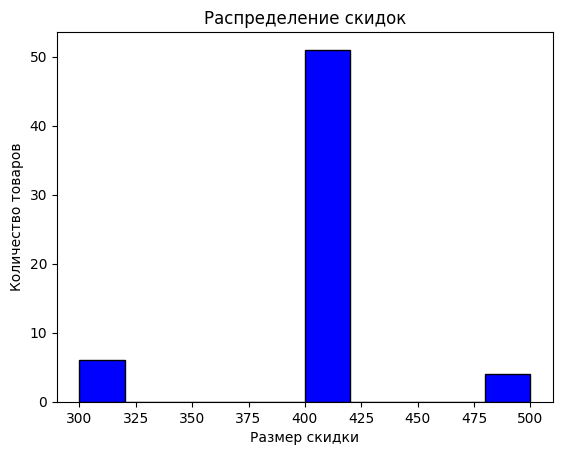

In [8]:
plot_distribution(df=optimal_df)

In [9]:
# Подсчитываем аплифты при выбранных скидках
calculate_uplifts(
    control_metrics=control_metrics,
    optimal_df=optimal_df,
)

Control mean_margin: 291063.91 руб.
Test mean_margin: 293667.35 руб.
Uplift: 0.89 %
Control mean_revenue: 1164255.64 руб.
Test mean_revenue: 1167892.24 руб.
Uplift: 0.31 %
